<a href="https://colab.research.google.com/github/Valaybundele/Few_Shot_MAML_Salinas/blob/main/MAML_Pytorch_Salinas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral

In [2]:
import torch
import torchvision
from torch.utils.data import Dataset
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os 
import scipy.io as sio
import random
from sklearn.decomposition import PCA
import spectral

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Global variables   
im_width, im_height, im_depth, im_channel = 11,11,30,1  #size of the input salinas patches

In [6]:
class MAML(nn.Module) :
  def __init__(self) :
    super(MAML,self).__init__()
    self.softmax = nn.Softmax(dim=1)
    layers = [nn.Conv3d(1,8,(7,3,3))]
    layers.append(nn.ReLU())
    layers.append(nn.Conv3d(8,16,(5,3,3)))
    layers.append(nn.ReLU())
    layers.append(nn.Conv3d(16,32,(3,3,3)))
    layers.append(nn.ReLU())
    layers.append(nn.Flatten())
    layers.append(nn.Dropout(0.4))
    layers.append(nn.Linear(14400,256))
    layers.append(nn.Dropout(0.4))
    layers.append(nn.Linear(256,128))
    layers.append(nn.Linear(128,3))
    self.model = nn.Sequential(*layers)
  def forward(self,x) :
    y = self.model(x)
    z = self.softmax(y)
    return z

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
maml_model = MAML().to(device)

In [9]:
def loadData(name):
    if name == 'IP':
        data = sio.loadmat('/content/drive/My Drive/Indian_pines_corrected.mat')['indian_pines_corrected']
        labels = sio.loadmat('/content/drive/My Drive/Indian_pines_gt.mat')['indian_pines_gt']
    if name == 'salinas' :
        data = sio.loadmat('/content/drive/My Drive/Hyperspectral Few Shot/Hyperspectral datasets/Salinas_corrected.mat')['salinas_corrected']
        labels = sio.loadmat('/content/drive/My Drive/Hyperspectral Few Shot/Hyperspectral datasets/Salinas_gt.mat')['salinas_gt']
    if name == 'pavia' :
        data = sio.loadmat('/content/drive/My Drive/PaviaU.mat')['paviaU']
        labels = sio.loadmat('/content/drive/My Drive/PaviaU_gt.mat')['paviaU_gt']
    if name == 'ksc' :
        data = sio.loadmat('/content/drive/My Drive/KSC.mat')['KSC']
        labels = sio.loadmat('/content/drive/My Drive/KSC_gt.mat')['KSC_gt']
    if name == 'botswana' :
        data = sio.loadmat('/content/drive/My Drive/Botswana.mat')['Botswana']
        labels = sio.loadmat('/content/drive/My Drive/Botswana_gt.mat')['Botswana_gt']
    return data, labels
# without reduction of 200 channels to 30 channels, memory error while creating cube 
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

def padWithZeros(X, margin):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)  # X :(145, 145, 30) --> (195, 195, 30) with window =25
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))  # (21025, 25, 25, 30)   
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))  # (21025,)
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]  
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]            
            patchIndex = patchIndex + 1
  
    patchesData = np.expand_dims(patchesData, axis=-1)
    return patchesData,patchesLabels

In [10]:
# creating input patches from the salinas dataset 
dataset1 = 'salinas'                                         # 16 classes   
sa_x1, sa_y = loadData(dataset1)                              #((512, 217, 204), (512, 217))
sa_x2,pca = applyPCA(sa_x1,numComponents=30)                   # ((512, 217, 20), (512, 217))
sa_X,sa_Y = createImageCubes(sa_x2, sa_y, windowSize=11)   #(111104, 9, 9, 20, 1) (111104,)
print(sa_X.shape,sa_Y.shape)

(111104, 11, 11, 30, 1) (111104,)


In [11]:
print(sa_x1.shape)
print(sa_y.shape)

(512, 217, 204)
(512, 217)


In [12]:
def patches_class(X,Y,n) :
  n_classes = n
  patches_list = []
  for i in range(1,n_classes+1):   # not considering class 0
    patchesData_Ith_Label = X[Y==i,:,:,:,:]
    patches_list.append(patchesData_Ith_Label)
  return patches_list 

In [13]:
patches_class_salinas = patches_class(sa_X,sa_Y,16) # class_wise list of patches #(16,) for class 0: (2009, 9, 9, 20, 1)

In [14]:
patches_class_salinas[0].shape

(2009, 11, 11, 30, 1)

In [15]:
train_class_indices = [0,1,2,3,4,5,6,7,8,11]
test_class_indices = [9,10,12,13,14,15]
train_patches_class = [patches_class_salinas[i] for i in train_class_indices]        #(10)
test_patches_class = [patches_class_salinas[i] for i in test_class_indices]        #(6) 
train_class_labels = [1,2,3,4,5,6,7,8,9,12]   
test_class_labels = [10,11,13,14,15,16]    #[11...16]

In [16]:
C = 3  # n_class
K1 = 5   # n_support
N = 15   # n_query
tC = 3   # classes in a test episode
im_height,im_width,im_depth = 11,11,30

In [17]:
def new_episode(patches_list,K,C,N,class_labels) :
  selected_classes = np.random.choice(class_labels,C,replace=False)  # Randomly choice C Classes out of classes available
  selected_classes = selected_classes.tolist()
  tsupport_patches = []
  tquery_patches = []
  query_labels = []
  support_labels = []
  for x in selected_classes :
    sran_indices = np.random.choice(len(patches_list[x-1]),K,replace=False)  # for class no X-1: select random sample no
    support_patches = patches_list[x-1][sran_indices,:,:,:,:]
    qran_indices = np.random.choice(len(patches_list[x-1]),N,replace=False)  # N Samples for Query
    query_patches = patches_list[x-1][qran_indices,:,:,:,:]
  # Support and Query patches belong to same Class 
    for i in range(N) :
      query_labels.append(x)    # N Samples for Query
    for i in range(K) :
      support_labels.append(x)    
    tquery_patches.extend(query_patches)
    tsupport_patches.extend(support_patches)
  temp1 = list(zip(tquery_patches, query_labels)) 
  random.shuffle(temp1)        # By Doing Shuffling, Support, Query Same class combination got mismatched - mitigated by support index
  tquery_patches, query_labels = zip(*temp1)
  temp2 = list(zip(tsupport_patches, support_labels)) 
  random.shuffle(temp2)        # By Doing Shuffling, Support, Query Same class combination got mismatched - mitigated by support index
  tsupport_patches, support_labels = zip(*temp2)
  tquery_patches = torch.from_numpy(np.reshape(np.asarray(tquery_patches, dtype=np.float32),(C*N,im_height,im_width,im_depth,1)))
  tsupport_patches = torch.from_numpy(np.reshape(np.asarray(tsupport_patches, dtype=np.float32),(C*K,im_height,im_width,im_depth,1)))
  tquery_patches = tquery_patches.permute(0,4,3,2,1)
  tsupport_patches = tsupport_patches.permute(0,4,3,2,1)
  return tquery_patches, tsupport_patches, query_labels, support_labels, selected_classes    

In [18]:
tquery_patches, tsupport_patches, query_labels, support_labels, selected_classes = new_episode(patches_class_salinas,K1,C,N,train_class_labels)

In [19]:
meta_opt = torch.optim.Adam(maml_model.parameters(), lr=0.0001, betas=(0.5, 0.999))      


In [20]:
maml_model.parameters

<bound method Module.parameters of MAML(
  (softmax): Softmax(dim=1)
  (model): Sequential(
    (0): Conv3d(1, 8, kernel_size=(7, 3, 3), stride=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(8, 16, kernel_size=(5, 3, 3), stride=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=14400, out_features=256, bias=True)
    (9): Dropout(p=0.4, inplace=False)
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): Linear(in_features=128, out_features=3, bias=True)
  )
)>

In [ ]:
!pip install higher


In [22]:
checkpoint_dir1 = '/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts'
checkpoint_prefix1 = os.path.join(checkpoint_dir1, "ckpt")

In [23]:
checkpoint = torch.load('/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts/ckpt1939597999119159199239279319359399439479')
maml_model.load_state_dict(checkpoint['model_state_dict'])
meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])


In [ ]:
#Training
import higher
epochs = 120
n_tasks = 15
for k in range(epochs) :
    maml_model.train()
    total_loss = 0
    accuracies = []
    n_inner_iter = 10
    inner_opt = torch.optim.SGD(maml_model.parameters(), lr=1e-1)
    meta_opt.zero_grad()
    for i in range(n_tasks) :
      with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
        tquery_patches, tsupport_patches, query_labels, support_labels, selected_classes = new_episode(patches_class_salinas,K1,C,N,train_class_labels)
        tsupport_patches = tsupport_patches.to(device)
        tquery_patches = tquery_patches.to(device)
        support_y = np.zeros((int(C*K1),C))                                          
        for i in range(int(C*K1)) :
          x = selected_classes.index(support_labels[i])                           # creation of 1-hot for true labels
          support_y[i][x] = 1. 
        support_y = torch.from_numpy(support_y).to(device)    
        query_y = np.zeros((int(C*N),C))                                        
        for i in range(int(C*N)) :
          x = selected_classes.index(query_labels[i])                           # creation of 1-hot for true labels
          query_y[i][x] = 1.
        query_y = torch.from_numpy(query_y).to(device)    
        for i in range(n_inner_iter) :
          s_logits = fnet(tsupport_patches)
          i_loss = F.cross_entropy(s_logits,support_y.argmax(axis=1))
          i_loss = torch.mean(i_loss)
          diffopt.step(i_loss)
        q_logits = fnet(tquery_patches)
        q_real = query_y.argmax(axis=1)
        q_real = q_real.long()
        q_loss = F.cross_entropy(q_logits,q_real)
        total_loss += q_loss
        q_loss.detach()
        q_loss.backward()        
        eq = (q_logits.argmax(dim=1) == q_real).sum().item()
        accuracy = eq/len(q_real)  
        accuracies.append(accuracy)
    meta_opt.step()
    accuracies = torch.from_numpy(np.asarray(accuracies))
    print(k,'Loss',total_loss,..., 'Accuracy', torch.mean(accuracies))
    if (k+1)%40==0 :
       checkpoint_prefix1 = checkpoint_prefix1 + str(k+360)
       torch.save({'model_state_dict': maml_model.state_dict(),
            'optimizer_state_dict': meta_opt.state_dict(),
            'loss': total_loss,
            }, checkpoint_prefix1)





In [24]:
print(len(test_patches_class))
print(test_class_labels)

6
[10, 11, 13, 14, 15, 16]


In [25]:
tune_set_5 = [[] for i in range(6)]
for j in range(6) :
  tune_set_5[j] = test_patches_class[j][:5,:,:,:,:]   # for each class first 5 samples taken

In [26]:
print(len(tune_set_5))
print(tune_set_5[0].shape)

6
(5, 11, 11, 30, 1)


In [27]:
def tune_episode(tune_set,tC,tK,tN,test_class_labels) :
  selected_classes = np.random.choice(test_class_labels,tC,replace=False)
  support_labels  = list(selected_classes)
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    np.random.shuffle(tune_set[y])    
    support_imgs = tune_set[y][:tK,:,:,:,:]    #Support 1, Query 4
    query_imgs = tune_set[y][tK:5,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(tN) :
      query_labels.append(x)
  temp1 = list(zip(query_patches, query_labels)) 
  random.shuffle(temp1) 
  query_patches, query_labels = zip(*temp1)
  query_patches = torch.from_numpy(np.reshape(np.asarray(query_patches,dtype=np.float32),(tC*tN,im_height,im_width,im_depth,1)))
  support_patches = torch.from_numpy(np.reshape(np.asarray(support_patches,dtype=np.float32),(tC*tK,im_height,im_width,im_depth,1)))
  query_patches = query_patches.permute(0,4,3,2,1)
  support_patches = support_patches.permute(0,4,3,2,1)
  return query_patches, support_patches, query_labels, support_labels, list(selected_classes)  

In [28]:
query_patches, support_patches, query_labels, support_labels, selected_classes = tune_episode(tune_set_5,4,1,4,test_class_labels)

In [29]:
checkpoint_dir2 = '/content/drive/MyDrive/Hyperspectral Few Shot/MAML/tuning/ckpts'
checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt")

In [30]:
checkpoint_tune = torch.load(checkpoint_prefix2)
maml_model.load_state_dict(checkpoint_tune['model_state_dict'])
meta_opt.load_state_dict(checkpoint_tune['optimizer_state_dict'])

In [ ]:
# Fine-tuning
n_episodes = 100
epochs = 41
import higher
n_tasks = 10
K2 = 1
N2 = 4

for k in range(epochs) :
    tune_accuracies = []
    maml_model.train()
    total_loss = 0
    accuracies = []
    n_inner_iter = 5
    inner_opt = torch.optim.SGD(maml_model.parameters(), lr=1e-1)
    meta_opt.zero_grad()
    for i in range(n_tasks) :
      with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
        query_patches, support_patches, query_labels, support_labels, selected_classes = tune_episode(tune_set_5,3,1,4,test_class_labels)        
        support_y = np.zeros((int(C*K2),C))
        support_patches = support_patches.to(device)
        query_patches = query_patches.to(device)                                           
        for i in range(int(C*K2)) :
          x = selected_classes.index(support_labels[i])                           # creation of 1-hot for true labels
          support_y[i][x] = 1. 
        support_y = torch.from_numpy(support_y).to(device)
        query_y = np.zeros((int(C*N2),C))                                           
        for i in range(int(C*N2)) :
          x = selected_classes.index(query_labels[i])                           # creation of 1-hot for true labels
          query_y[i][x] = 1.
        query_y = torch.from_numpy(query_y).to(device)
        for i in range(n_inner_iter) :
          s_logits_t = fnet(support_patches)
          i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
          i_loss = torch.mean(i_loss)
          diffopt.step(i_loss)
        q_logits = fnet(query_patches)
        q_real = query_y.argmax(axis=1)
        q_real = (q_real).long()
        q_loss = F.cross_entropy(q_logits,q_real)
        q_loss.detach()
        total_loss += q_loss
        q_loss.backward()
        eq = (q_logits.argmax(dim=1) == q_real).sum().item()
        accuracy = eq/len(q_real)  
        tune_accuracies.append(accuracy)
    meta_opt.step()
    tune_accuracies = torch.from_numpy(np.asarray(tune_accuracies))
    print(k,'Loss',total_loss,..., 'Accuracy', torch.mean(tune_accuracies))
    if (k+1)%20==0 :
       torch.save({'model_state_dict': maml_model.state_dict(),
            'optimizer_state_dict': meta_opt.state_dict(),
            'loss': total_loss,
            }, checkpoint_prefix2)




In [31]:
def test_episode(test_patches_class,test_class_labels,test_C,test_K,i,f) :
  selected_classes = test_class_labels[i:f]   # [1, 2, 3, 4, 5, 6, 7, 8]
  support_labels = []
  query_labels = []
  support_patches = []
  query_patches = []
  for x in selected_classes :
    y = test_class_labels.index(x)
    support_imgs = test_patches_class[y][:test_K,:,:,:,:]
    query_imgs = test_patches_class[y][test_K:,:,:,:,:]
    support_patches.extend(support_imgs)
    query_patches.extend(query_imgs)
    for i in range(query_imgs.shape[0]) :
      query_labels.append(x)
    for i in range(test_K) :
      support_labels.append(x)
  temp1 = list(zip(query_patches, query_labels)) 
  random.shuffle(temp1) 
  query_patches, query_labels = zip(*temp1)
  x = len(query_labels)
  query_patches = torch.from_numpy(np.reshape(np.asarray(query_patches,dtype=np.float32),(x,im_height,im_width,im_depth,1)))
  support_patches = torch.from_numpy(np.reshape(np.asarray(support_patches,dtype=np.float32),(test_C*test_K,im_height,im_width,im_depth,1)))
  query_patches = query_patches.permute(0,4,3,2,1)
  support_patches = support_patches.permute(0,4,3,2,1)
  return query_patches, support_patches, query_labels, support_labels,x, list(selected_classes)    

In [32]:
query_patches, support_patches, query_labels, support_labels, x, selected_classes = test_episode(test_patches_class,test_class_labels,3,5,0,3)

In [33]:
# Testing
for epoch in range(1): 
    import higher   
    n_tasks = 1
    total_loss = 0
    n_inner_iter = 5
    inner_opt = torch.optim.SGD(maml_model.parameters(), lr=1e-1)
    meta_opt.zero_grad()
    for i in range(n_tasks) :
      with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
        tquery_patches1, tsupport_patches1, query_labels1, support_labels1, x1, selected_classes1 = test_episode(test_patches_class,test_class_labels,3,5,0,3)        
        support_y1 = np.zeros((int(C*K1),C))
        tsupport_patches1 = tsupport_patches1.to(device)
        tquery_patches1 = tquery_patches1.to(device)                                             
        for i in range(int(C*K1)) :
          x = selected_classes1.index(support_labels1[i])                           # creation of 1-hot for true labels
          support_y1[i][x] = 1. 
        support_y1 = torch.from_numpy(support_y1).to(device)
        query_y1 = np.zeros((int(x1),C))                                         
        for i in range(int(x1)) :
          x = selected_classes1.index(query_labels1[i])                           # creation of 1-hot for true labels
          query_y1[i][x] = 1.
        query_y1 = torch.from_numpy(query_y1).to(device)
        for i in range(n_inner_iter) :
          s_logits_t = fnet(tsupport_patches1)
          i_loss = F.cross_entropy(s_logits_t,support_y1.argmax(axis=1))
          i_loss = torch.mean(i_loss)
          diffopt.step(i_loss)
        q_logits1 = fnet(tquery_patches1)
        q_real1 = query_y1.argmax(axis=1)
        q_real1 = (q_real1).long()
        q_loss = F.cross_entropy(q_logits1,q_real1)
        q_loss.detach()
        total_loss += q_loss
        #q_loss.backward()
        eq1 = (q_logits1.argmax(dim=1) == q_real1).sum().item()
        accuracy1 = eq1/len(q_real1)  
        print(accuracy1) #overall accuracy for the first three classes
        # Class-wise accuracies calculation
        mean_correct_class = [[] for i in range(C)]
        mean_correct_pred = [[] for i in range(C)]
        classwise_mean_acc = [[] for i in range(C)]
        q_pred = q_logits1.argmax(dim=1)
        for i in range(int(x1)):
          x = selected_classes1.index(query_labels1[i])
          mean_correct_class[x].append('4')
          if(q_pred[i] == x) :
            mean_correct_pred[x].append('4')
        for i in range(C) :
           z = len(mean_correct_pred[i])/len(mean_correct_class[i])
           classwise_mean_acc[i].append(z)
           print(classwise_mean_acc[i])

0.9390127692014485
[0.9046746104491292]
[0.9924741298212606]
[1.0]


In [34]:
for epoch in range(1): 
    n_tasks = 1
    total_loss = 0
    n_inner_iter = 10
    inner_opt = torch.optim.SGD(maml_model.parameters(), lr=1e-1)
    meta_opt.zero_grad()
    for i in range(n_tasks) :
      with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
        tquery_patches3, tsupport_patches3, query_labels3, support_labels3, x3, selected_classes3 = test_episode(test_patches_class,test_class_labels,3,5,3,6)        
        support_y3 = np.zeros((int(C*K1),C))
        tsupport_patches3 = tsupport_patches3.to(device)
        tquery_patches3 = tquery_patches3.to(device)                                              #(150,10)
        for i in range(int(C*K1)) :
          x = selected_classes3.index(support_labels3[i])                           # creation of 1-hot for true labels
          support_y3[i][x] = 1. 
        support_y3 = torch.from_numpy(support_y3).to(device)
        query_y3 = np.zeros((int(x3),C))                                              #(150,10)
        for i in range(int(x3)) :
          x = selected_classes3.index(query_labels3[i])                           # creation of 1-hot for true labels
          query_y3[i][x] = 1.
        query_y3 = torch.from_numpy(query_y3).to(device)
        for i in range(n_inner_iter) :
          s_logits_t = fnet(tsupport_patches3)
          i_loss = F.cross_entropy(s_logits_t,support_y3.argmax(axis=1))
          i_loss = torch.mean(i_loss)
          diffopt.step(i_loss)
        q_logits3 = fnet(tquery_patches3)
        q_real3 = query_y3.argmax(axis=1)
        q_real3 = (q_real3).long()
        q_loss = F.cross_entropy(q_logits3,q_real3)
        q_loss.detach()
        total_loss += q_loss
        #q_loss.backward()
        eq3 = (q_logits3.argmax(dim=1) == q_real3).sum().item()
        accuracy3 = eq3/len(q_real3)  
        print(accuracy3) #overall accuracy for the last three classes
        # CLasswise accuracy calculation 
        mean_correct_class3 = [[] for i in range(C)]
        mean_correct_pred3 = [[] for i in range(C)]
        classwise_mean_acc3 = [[] for i in range(C)]
        q_pred3 = q_logits3.argmax(dim=1)
        for i in range(int(x3)):
          x = selected_classes3.index(query_labels3[i])
          mean_correct_class3[x].append('4')
          if(q_pred3[i] == x) :
            mean_correct_pred3[x].append('4')
        for i in range(C) :
           z = len(mean_correct_pred3[i])/len(mean_correct_class3[i])
           classwise_mean_acc3[i].append(z)
           print(classwise_mean_acc3[i]) 

0.7877591312931885
[0.615962441314554]
[0.9482307586396805]
[0.24250832408435072]


In [35]:
# Overall accuracy for all the six test classes
predictions_f = torch.cat((q_logits1,q_logits3),dim=0)
real_f = torch.cat((q_real1,q_real3),dim=0)
eq = torch.eq(predictions_f.argmax(dim=1),real_f)
acc = torch.sum(eq)/real_f.shape[0]
print(acc) #overall accuracy

tensor(0.8394, device='cuda:0')


In [36]:
#Kappa accuracy
import sklearn
real_f = real_f.cpu()
real_f = real_f.detach().numpy()
predictions_f = predictions_f.argmax(axis=1)
predictions_f = predictions_f.cpu()
predictions_f = predictions_f.detach().numpy()
sklearn.metrics.cohen_kappa_score(real_f,predictions_f)

0.7215364083807643

**Visualisation**

In [37]:
PATCH_SIZE = 11
sa_x_padded = padWithZeros(sa_x2, PATCH_SIZE//2)

In [38]:
sa_x2.shape

(512, 217, 30)

In [39]:
sa_x_padded.shape

(522, 227, 30)

In [40]:
sa_y.shape

(512, 217)

In [41]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]    
    return patch

In [42]:
#for train classes
train_class_labels = [1,2,3,4,5,6,7,8,9,12] 
n_tasks1 = 1
import higher  
device = 'cuda'
inner_opt = torch.optim.SGD(maml_model.parameters(), lr=1e-1)
n_inner_iter = 5
test_class_labels = [10,11,13,14,15,16]
height,width = 512,217
outputs = torch.from_numpy(np.zeros((height,width)))
for i in range(height):
    for j in range(width):
        target = int(sa_y[i,j])  
        if target == 0 :     # avoid label 0
            continue
        elif target <= 3 :
            checkpoint = torch.load('/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts/ckpt1939597999119159199239279319359399439479')
            maml_model.load_state_dict(checkpoint['model_state_dict'])
            meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])         
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32') 
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = train_class_labels[0:3]
            support_patches = []
            support_labels = []
            for x in selected_classes :
              y = train_class_labels.index(x)
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for o in range(K1) :
                support_labels.append(x)
            for p in range(n_tasks1) :
              with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                   
                  for o in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[o])                           # creation of 1-hot for true labels
                    support_y[o][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)

                  for b in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)
                  outputs[i][j] = index + 1         
        elif target in train_class_labels[3:6]: 
            checkpoint = torch.load('/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts/ckpt1939597999119159199239279319359399439479')
            maml_model.load_state_dict(checkpoint['model_state_dict'])
            meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = train_class_labels[3:6]
            support_patches = []
            support_labels = []
            for x in selected_classes :
              y = train_class_labels.index(x)
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for o in range(K1) :
                support_labels.append(x)
            for p in range(n_tasks1) :
              with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                  
                  for o in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[o])                           # creation of 1-hot for true labels
                    support_y[o][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)

                  for o in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)
                  outputs[i][j] = index + 4
        elif target in train_class_labels[6:9]: 
            checkpoint = torch.load('/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts/ckpt1939597999119159199239279319359399439479')
            maml_model.load_state_dict(checkpoint['model_state_dict'])
            meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])   
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')   
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = train_class_labels[6:9]
            support_patches = []
            support_labels = []
            for x in selected_classes :
              y = train_class_labels.index(x)
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for o in range(K1) :
                support_labels.append(x)
            for p in range(n_tasks1) :
              with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                    
                  for o in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[o])                           # creation of 1-hot for true labels
                    support_y[o][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)
                  for o in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)
                  outputs[i][j] = index + 7        
        elif target in train_class_labels[7:10]: 
            checkpoint = torch.load('/content/drive/MyDrive/Hyperspectral Few Shot/MAML/training/ckpts/ckpt1939597999119159199239279319359399439479')
            maml_model.load_state_dict(checkpoint['model_state_dict'])
            meta_opt.load_state_dict(checkpoint['optimizer_state_dict'])
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j) 
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')  
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = train_class_labels[7:10]
            support_patches = []
            support_labels = []
            for x in selected_classes :
              y = train_class_labels.index(x)
              support_imgs = train_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for o in range(K1) :
                support_labels.append(x)
            for p in range(n_tasks1) :
              with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                    
                  for o in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[o])                           # creation of 1-hot for true labels
                    support_y[o][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)

                  for o in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)
                  if index < 2 :
                    outputs[i][j] = index + 8
                  if index == 2 :
                    outputs[i][j] = index + 10              

In [43]:
#For test classes
n_tasks1 = 1
labels = []
n_out = np.zeros((height,width))
train_class_labels = [1,2,3,4,5,6,7,8,9,12]   
test_class_labels = [10,11,13,14,15,16]
for i in range(height):
    for j in range(width):
        target = int(sa_y[i,j])    
        if target == 0 :     # avoid label 0
            continue
        elif target in test_class_labels[0:3]:
            checkpoint_tune = torch.load(checkpoint_prefix2)
            maml_model.load_state_dict(checkpoint_tune['model_state_dict'])
            meta_opt.load_state_dict(checkpoint_tune['optimizer_state_dict'])           
            query_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')    
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = test_class_labels[0:3]
            support_patches = []
            support_labels = []
            for x in selected_classes :
              y = test_class_labels.index(x)
              support_imgs = test_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for b in range(K1) :
                support_labels.append(x)
            with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                  
                  for b in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[b])                           # creation of 1-hot for true labels
                    support_y[b][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)

                  for b in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)
                  if index < 2 :
                    outputs[i][j] = index + 10 
                  elif index == 2 :
                    outputs[i][j] = index + 11
        elif target in test_class_labels[3:6]:
            checkpoint_tune = torch.load(checkpoint_prefix2)
            maml_model.load_state_dict(checkpoint_tune['model_state_dict'])
            meta_opt.load_state_dict(checkpoint_tune['optimizer_state_dict'])
            query_labels = []
            support_labels = []
            query_labels.append(target)
            image_patch = Patch(sa_x_padded,i,j)   
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')  
            query_patches = torch.from_numpy(X_test_image).to(device)  
            query_patches = query_patches.permute(0,4,3,2,1)
            selected_classes = test_class_labels[3:6]
            support_patches = []
            for x in selected_classes :
              y = test_class_labels.index(x)
              support_imgs = test_patches_class[y][:5,:,:,:,:]
              support_patches.extend(support_imgs)
              for b in range(K1) :
                support_labels.append(x)
            with higher.innerloop_ctx(maml_model, inner_opt, copy_initial_weights=False) as (fnet, diffopt): 
                  support_y = np.zeros((int(C*K1),C))                                   
                  for b in range(int(C*K1)) :
                    x = selected_classes.index(support_labels[b])                           # creation of 1-hot for true labels
                    support_y[b][x] = 1. 
                  support_y = torch.from_numpy(support_y).to(device)
                  support_patches = torch.from_numpy(np.asarray(support_patches,dtype=np.float32)).to(device)
                  support_patches = support_patches.permute(0,4,3,2,1)
                  for b in range(n_inner_iter) :
                    s_logits_t = fnet(support_patches)
                    i_loss = F.cross_entropy(s_logits_t,support_y.argmax(axis=1))
                    i_loss = torch.mean(i_loss)
                    diffopt.step(i_loss)
                  q_logits = fnet(query_patches)
                  index = torch.argmax(q_logits,axis=1)              
                  outputs[i][j] = index + 14         

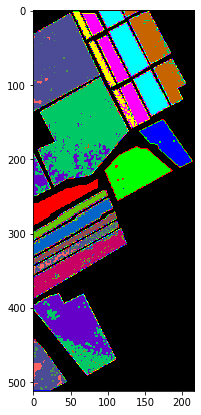

In [44]:
predict_image = spectral.imshow(classes = np.asarray(outputs).astype(int),figsize = (7,7)) 

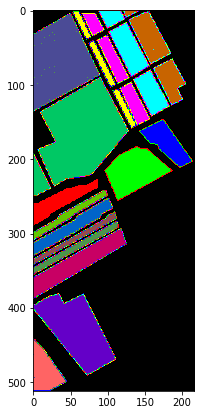

In [ ]:
ground_truth = spectral.imshow(classes = sa_y,figsize =(7,7))   # 0-16